# Ridge Regression

In [1]:
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Model packages
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from time import time
import pprint
import joblib
from functools import partial

from sklearn.model_selection import KFold, StratifiedKFold

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer

# Skopt functions
# conda install -c conda-forge scikit-optimize
from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper, DeltaYStopper
from skopt.space import Real, Categorical, Integer

# Data processing
from sklearn.preprocessing import OrdinalEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Suppressing warnings because of skopt verbosity
import warnings
warnings.filterwarnings("ignore")

#display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

path = '/home/jln436/Internship_AUMC/'

In [2]:
# Initialize some variables that will be consistent throughout
n_folds = 5 # For stratified cross-validatio
random_seed = 42
nbins = 10 # For stratified K-fold

In [3]:
# Load training sets
df = pd.read_csv(path + 'output/dfs/X_train_final_minus.csv')
target = pd.read_csv(path + 'output/dfs/y_train_final.csv')

In [4]:
# Remove id number because not useful for predictions
df.drop(columns = ['respnr'], inplace = True)

In [5]:
# Split into training and validation set:
X, X_val, y, y_val = train_test_split(df, target.target, test_size=0.30, random_state=random_seed)
# Stratifying the target
X.reset_index(inplace = True, drop=True)
y_stratified = pd.cut(y, bins=nbins, labels=False)

In [6]:
#Scale features
scaler = StandardScaler()
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X), columns = X.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns = X_val.columns)

# Bayesian Hyperparameter tuning

In [7]:
# Helpful Links:
## explanation: https://towardsdatascience.com/a-conceptual-explanation-of-bayesian-model-based-hyperparameter-optimization-for-machine-learning-b8172278050f
## tutorial: https://www.kaggle.com/code/lucamassaron/tutorial-bayesian-optimization-with-lightgbm/notebook

In [8]:
# Reporting util for different optimizers
def report_perf(optimizer, X, y, title="model", callbacks=None):
    """
    A wrapper for measuring time and performances of different optmizers
    
    optimizer = a sklearn or a skopt optimizer
    X = the training set 
    y = our target
    title = a string label for the experiment
    """
    start = time()
    
    if callbacks is not None:
        optimizer.fit(X, y, callback=callbacks)
    else:
        optimizer.fit(X, y)
        
    d=pd.DataFrame(optimizer.cv_results_)
    best_score = optimizer.best_score_
    best_score_std = d.iloc[optimizer.best_index_].std_test_score
    best_params = optimizer.best_params_
    
    print((title + " took %.2f seconds,  candidates checked: %d, best CV score: %.3f "
           + u"\u00B1"+" %.3f") % (time() - start, 
                                   len(optimizer.cv_results_['params']),
                                   best_score,
                                   best_score_std))    
    print('Best parameters:')
    pprint.pprint(best_params)
    print()
    return best_params, d

In [9]:
# Setting the scoring function
scoring = make_scorer(partial(mean_squared_error, squared=False), 
                      greater_is_better=False)

In [10]:
# Setting the validation strategy
skf = StratifiedKFold(n_splits=n_folds, 
                      shuffle=True, 
                      random_state=random_seed)

cv_strategy = list(skf.split(X, y_stratified))

In [11]:
# Setting the basic regressor
reg = Ridge(random_state = random_seed)

In [12]:
# Setting the search space
# max_depth and n_estimators (increase)
search_spaces = {
    'alpha': Real(0.0001, 100, 'log-uniform'),             # Regularization parameter
    'fit_intercept': Categorical([True, False]),         # Whether to fit the intercept
    #'max_iter': Integer(15000, 18000),                      # max number of iterations 
    'tol': Real(0.00001, 10.0, 'log-uniform'),             # Tolerance    
    'solver': Categorical(['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']),            # Whether to use warm start
    #'positive': Categorical([True, False])              # Whether to force coefficients to be positive
   }

In [13]:
# Wrapping everything up into the Bayesian optimizer
opt = BayesSearchCV(estimator=reg,                                    
                    search_spaces=search_spaces,                      
                    scoring=scoring,                           
                    cv=cv_strategy,                                           
                    n_iter=100,                                        # max number of trials
                    n_points=3,                                       # number of hyperparameter sets evaluated at the same time
                    n_jobs=-1,                                        # number of jobs
                    iid=False,                                        # if not iid it optimizes on the cv score
                    return_train_score=False,                         
                    refit=False,                                      
                    optimizer_kwargs={'base_estimator': 'GP'},        # optmizer parameters: we use Gaussian Process (GP)
                    random_state=0)                                   # random state for replicability


In [14]:
# Running the optimizer
overdone_control = DeltaYStopper(delta=0.0001)               # We stop if the gain of the optimization becomes too small
time_limit_control = DeadlineStopper(total_time=60 * 60 * 7) # We impose a time limit (7 hours)

best_params, d = report_perf(opt, X, y,'Ridge_regression', 
                          callbacks=[overdone_control, time_limit_control])

/home/jln436/.conda/envs/internship3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jln436/.conda/envs/internship3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jln436/.conda/envs/internship3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jln436/.conda/envs/internship3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jln436/.conda/envs/internship3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w

Ridge_regression took 298.54 seconds,  candidates checked: 100, best CV score: -5.744 ± 0.584
Best parameters:
OrderedDict([('alpha', 70.11348955265761),
             ('fit_intercept', True),
             ('solver', 'saga'),
             ('tol', 0.08086066096201301)])



In [15]:
best_params

OrderedDict([('alpha', 70.11348955265761),
             ('fit_intercept', True),
             ('solver', 'saga'),
             ('tol', 0.08086066096201301)])

### Evaluate the best parameters

In [16]:
# Make predictions on the validation data set:
# Transferring the best parameters to our basic regressor
model = Ridge(random_state=random_seed,
           **best_params)
model.fit(X, y)
# Make predictions:
y_pred = model.predict(X_val)

In [17]:
# accuracy check
mse = mean_squared_error(y_val, y_pred)
rmse = mse**(0.5)
mae = mean_absolute_error(y_val, y_pred)
print("MAE: %.2f" % mae)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % rmse) 

MAE: 4.80
MSE: 33.87
RMSE: 5.82


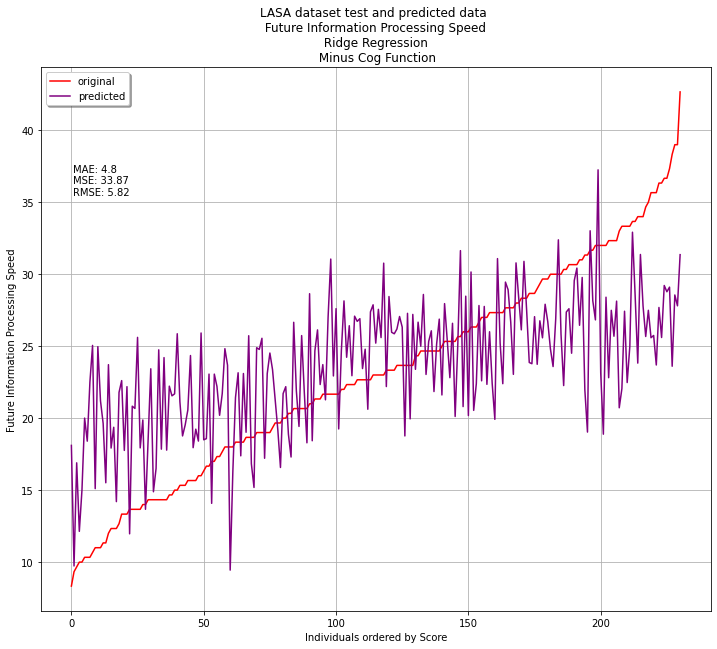

In [18]:
tmp_df = pd.DataFrame(data = y_val)
tmp_df['predicted'] = y_pred
tmp_df = tmp_df.sort_values(by=['target'])
# visualizing in a plot
x_ax = range(len(y_val))
plt.figure(figsize=(12, 10))
plt.plot(x_ax, tmp_df.target, label="original", color = "red")
plt.plot(x_ax, tmp_df.predicted, label="predicted", color = "purple")
plt.title("LASA dataset test and predicted data \n Future Information Processing Speed \n Ridge Regression \n Minus Cog Function")
plt.xlabel('Individuals ordered by Score')
plt.ylabel('Future Information Processing Speed')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.text(0.5, 35.5, 'MAE: ' + str(round(mae,2)) + '\nMSE: ' + str(round(mse,2)) + '\nRMSE: ' + str(round(rmse,2)), fontsize = 10)
plt.show()

## Importance through coefficients

In [19]:
coeffs = model.coef_         # dense np.array

In [20]:
Ridge_coefficients = pd.DataFrame(data = X.columns.values.tolist(), columns = ['features'])
Ridge_coefficients['coefficients'] = coeffs
#Ridge_coefficients = Ridge_coefficients.sort_values('coefficients', ascending = False)
Ridge_coefficients= Ridge_coefficients.reindex(Ridge_coefficients.coefficients.abs().sort_values(ascending=False).index)

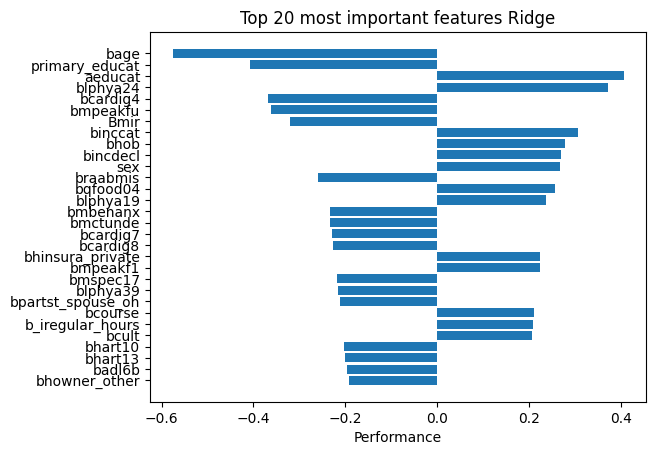

In [21]:
plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
y_pos = np.arange(30)

ax.barh(y_pos, Ridge_coefficients.coefficients[0:30], align='center')
ax.set_yticks(y_pos, labels=Ridge_coefficients.features[0:30])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Performance')
ax.set_title('Top 20 most important features Ridge')

plt.show()

In [22]:
# Save Ridge Coefficients
Ridge_coefficients.to_csv(path + 'output/Importances/Ridge_Importances_no_cog_tests.csv', index = False)

## Save Training Model

In [23]:
import pickle
filename = path + '/output/models/Ridge_bayesian_training_model_no_cog_tests.sav'

In [24]:
# save the model to disk
pickle.dump(model, open(filename, 'wb'))

In [25]:
# load the model from disk
model = pickle.load(open(filename, 'rb'))
